In [1]:
%load_ext autoreload
%autoreload 2

In [31]:

from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.losses import OT_loss

from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

from MIOFlow.models import ToyODE, ToyModel

import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

data_name = 'growth_rate'
RAW_DATA_DIR = os.path.join('../../data', 'raw',data_name)
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed',data_name)

print(PROCESSED_DATA_DIR)

../../data/processed/growth_rate


# Load dataset

In [32]:
df0 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,'dying_example_growth_rate.csv'))

scaler = StandardScaler()
df0[['d1', 'd2']] = scaler.fit_transform(df0[['d1', 'd2']])
df0.head()

d1        d2  samples  growth_rate
0 -0.928599  0.411794        0     1.153308
1 -0.951582 -1.774723        0     1.107995
2 -0.871550 -0.473042        0     1.156028
3 -1.018582 -0.253726        0     1.076405
4 -1.590069 -0.248106        0     0.761930

In [33]:
df1 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"growth_rate_sample.csv"),index_col=0)
# Keep only rows where indices match between df0 and df1
common_indices = df0.index.intersection(df1.index)
df0 = df0.loc[common_indices]
df1 = df1.loc[common_indices]

assert df0.index.equals(df1.index)
scaler = StandardScaler()
df0[['d1', 'd2']] = scaler.fit_transform(df0[['d1', 'd2']])
df = df0.copy()
threshold = 0.4

desired_idx = list(df1[df1['samples'] != 0].index) + list(df1[(df1['samples'] == 0) & (df1['growth_rate'] > threshold)].index)
df = df.loc[desired_idx]

# # Get size of smallest group
min_size = df['samples'].value_counts().min()

# # Subsample each group to have min_size samples
df = df.groupby('samples').apply(lambda x: x.sample(n=min_size, random_state=42)).droplevel(0)


In [34]:
df['samples'].value_counts()

samples
0    200
1    200
2    200
3    200
Name: count, dtype: int64

<Axes: xlabel='d1', ylabel='d2'>

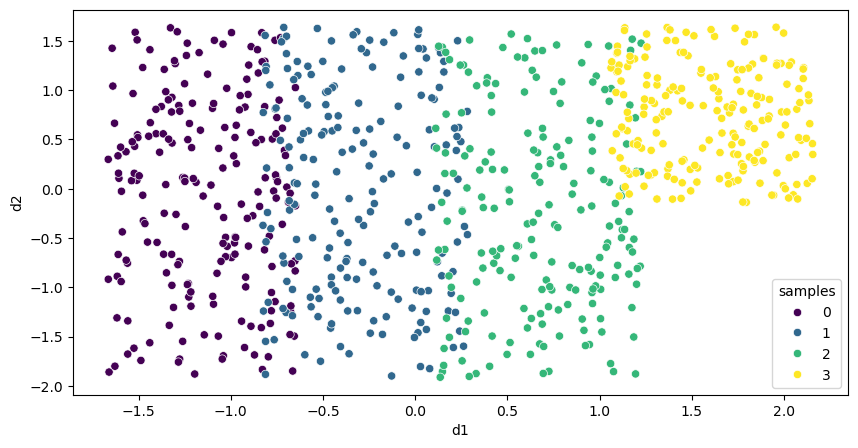

In [35]:
fig = plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis')

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [36]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [37]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [38]:
len(df.columns) - 1
groups = sorted(df.samples.unique())

In [39]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 3
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [40]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [41]:
set_seeds(10)

#Directory where results are saved
exp_name = os.path.join(PROCESSED_DATA_DIR,'results','test')

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 5

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
# sde_scales = len(groups)*[0.1] 
sde_scales = len(groups)*[0.5] 


if recon:    
    model_features = gae_embedded_dim



In [47]:
ode = ToyODE(model_features, layers, activation,scales=sde_scales,n_aug=2)
model = ToyModel(ode,method='rk4',rtol=None, atol=None, use_norm=False)

In [48]:
model

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)

In [46]:
# model = make_model(
#     model_features, layers, 
#     activation=activation, scales=sde_scales, use_cuda=use_cuda
# )

In [49]:
gmodel = torch.load(os.path.join(PROCESSED_DATA_DIR,'gmodel_full4.pt'),weights_only=False)

In [50]:
gmodel

GrowthRateModel(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [51]:
# Basically "batch size"
sample_size=(100, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'sinkhorn'
# criterion = config_criterion(criterion_name)
criterion = OT_loss(which='sinkhorn', use_cuda=use_cuda, detach_mass=False)

# optimizer = torch.optim.AdamW(model.parameters())
optimizer = torch.optim.AdamW([
    {'params': model.parameters(), 'lr': 1e-3},
    {'params': gmodel.parameters(), 'lr': 1e-5}  # different learning rate for gmodel
])

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [52]:
opts = {
    'phate_dims': 2,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [53]:
exp_dir, logger = setup_exp(exp_name, opts, exp_name) 

In [54]:
# np.random.seed(32)
# groups = sorted(df['samples'].unique())
# sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
# from MIOFlow.utils import sample
# data_t0 = sample(
#     df, np.min(groups), size=(n_points, ), 
#     replace=False, to_torch=True, use_cuda=use_cuda
# )

In [55]:
model

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)

In [61]:
model

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)

In [62]:
model.func.__dir__()

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [63]:
gmodel.train()
model.train()
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    # n_conditions=0,
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    use_penalty=True, lambda_energy=0.001,
    # use_penalty=False, lambda_energy=0.0,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
    growth_rate_model=gmodel
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x3 and 2x64)

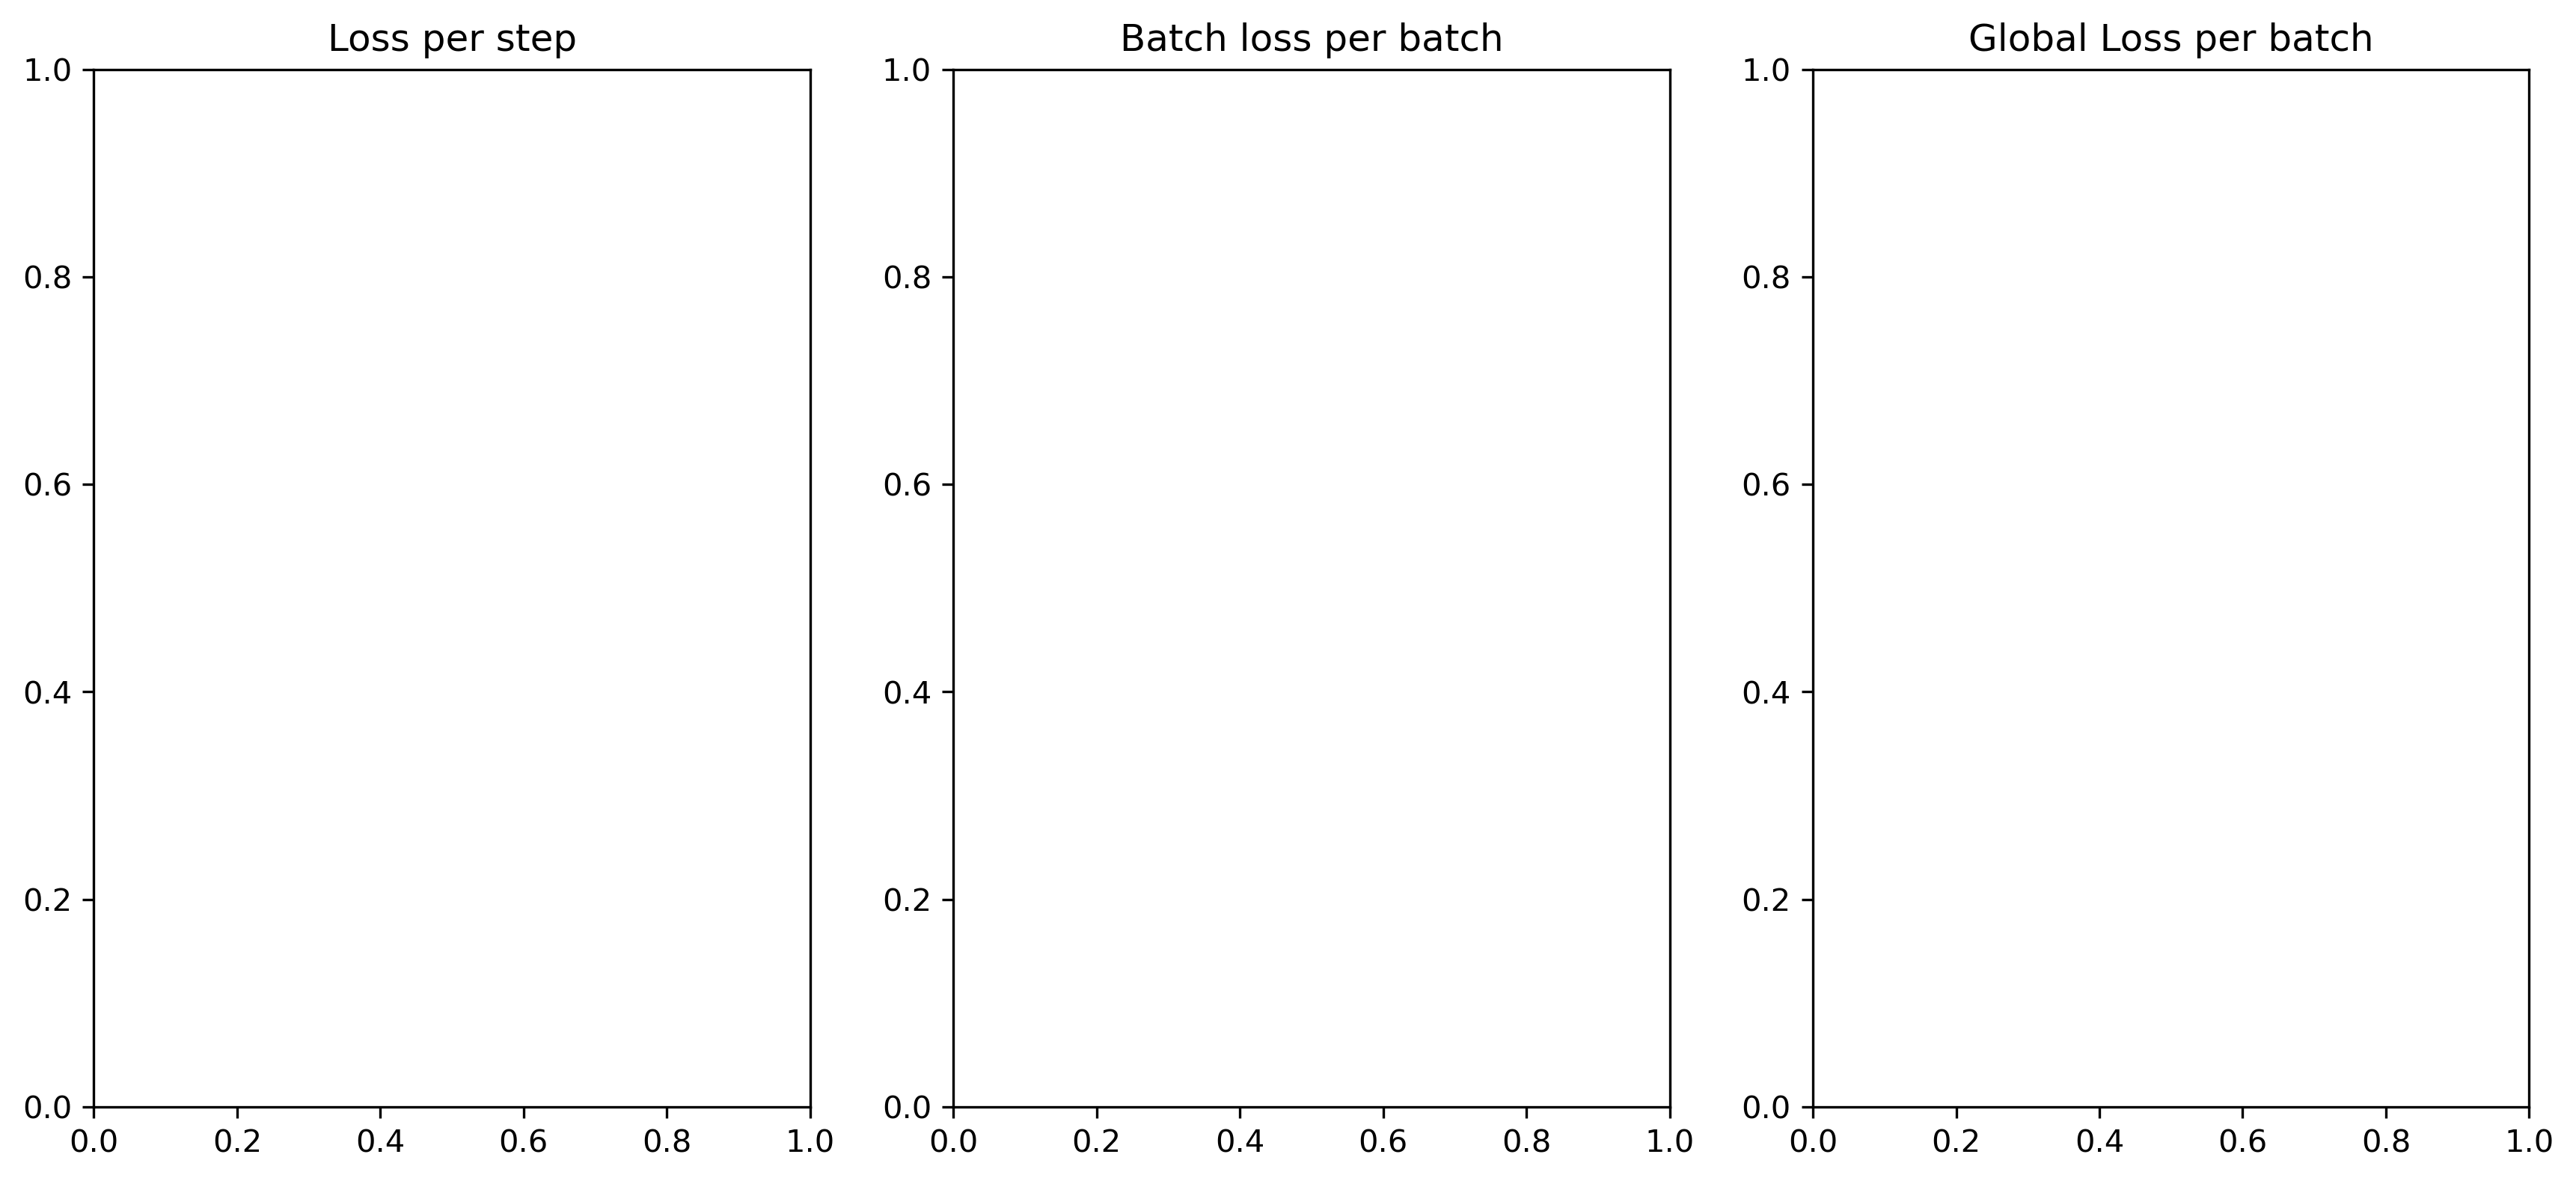

In [22]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [23]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


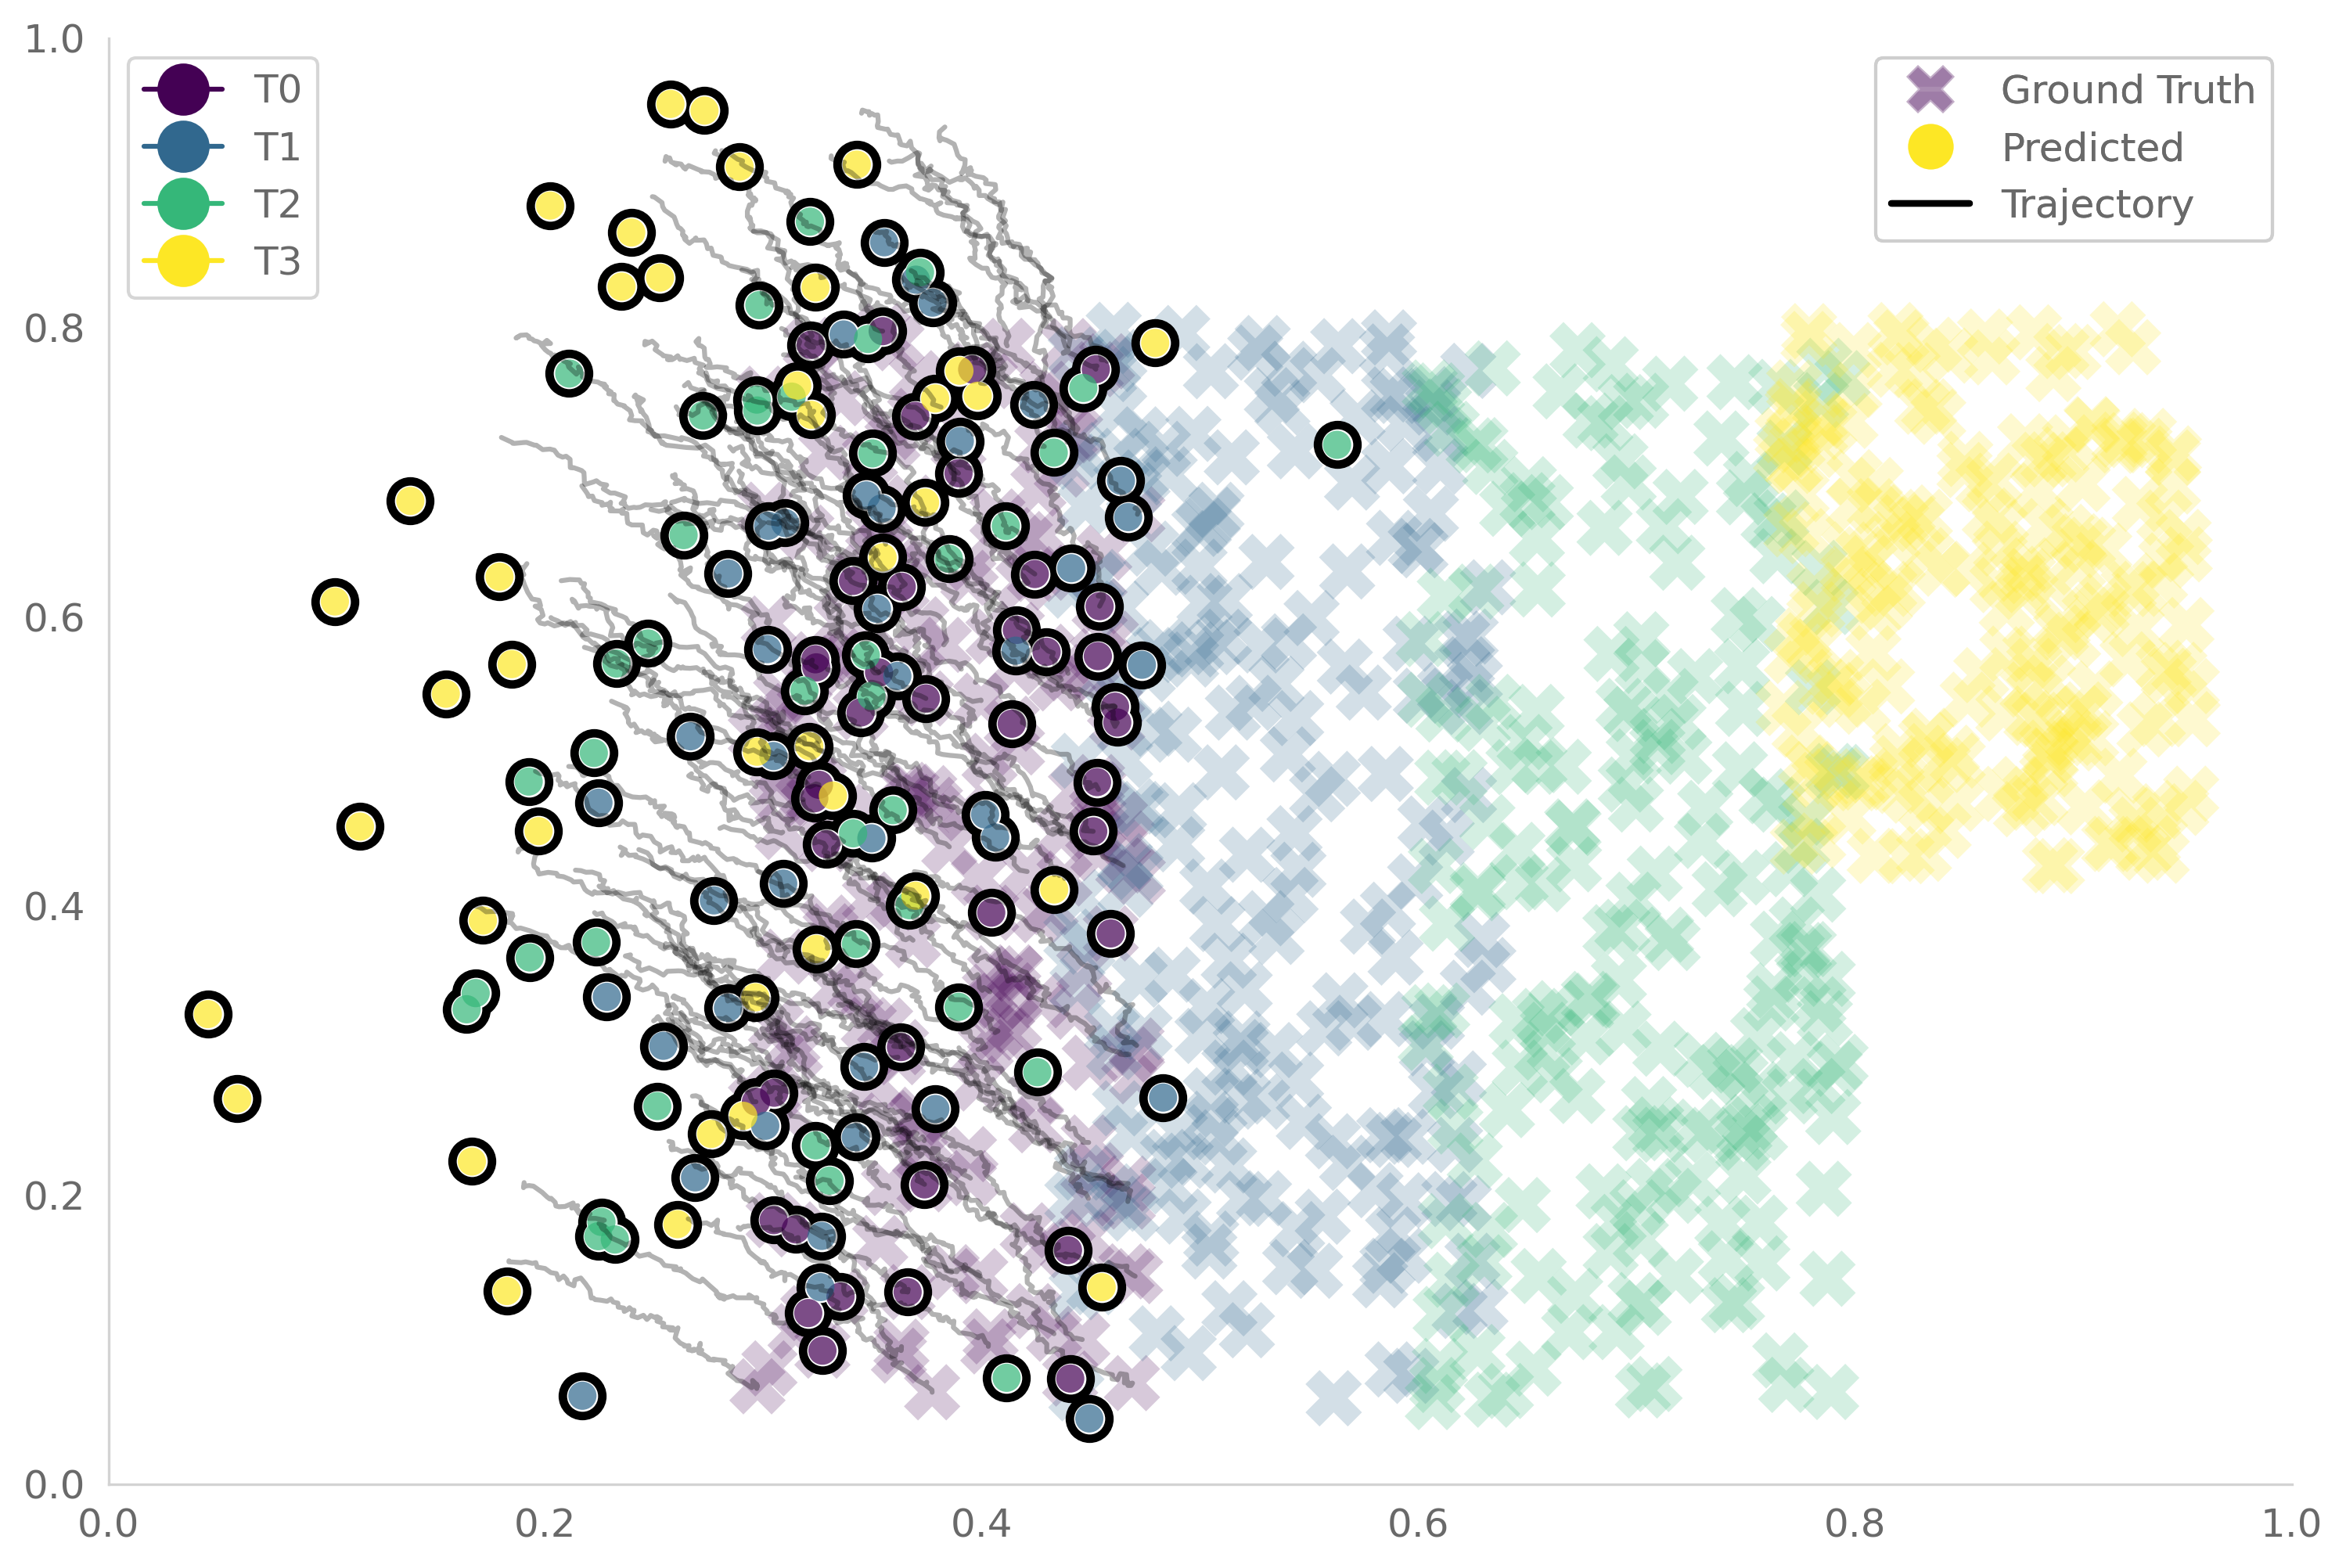

In [24]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

In [3]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df0['d1'], df0['d2'],
                c=df0['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))


NameError: name 'np' is not defined

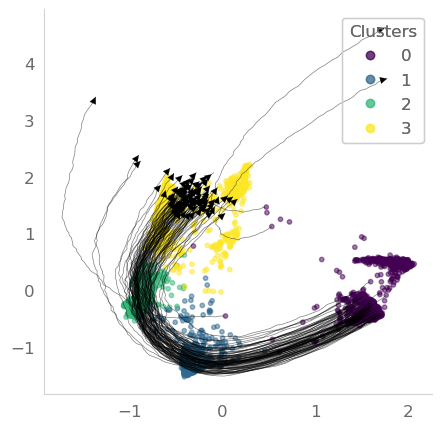

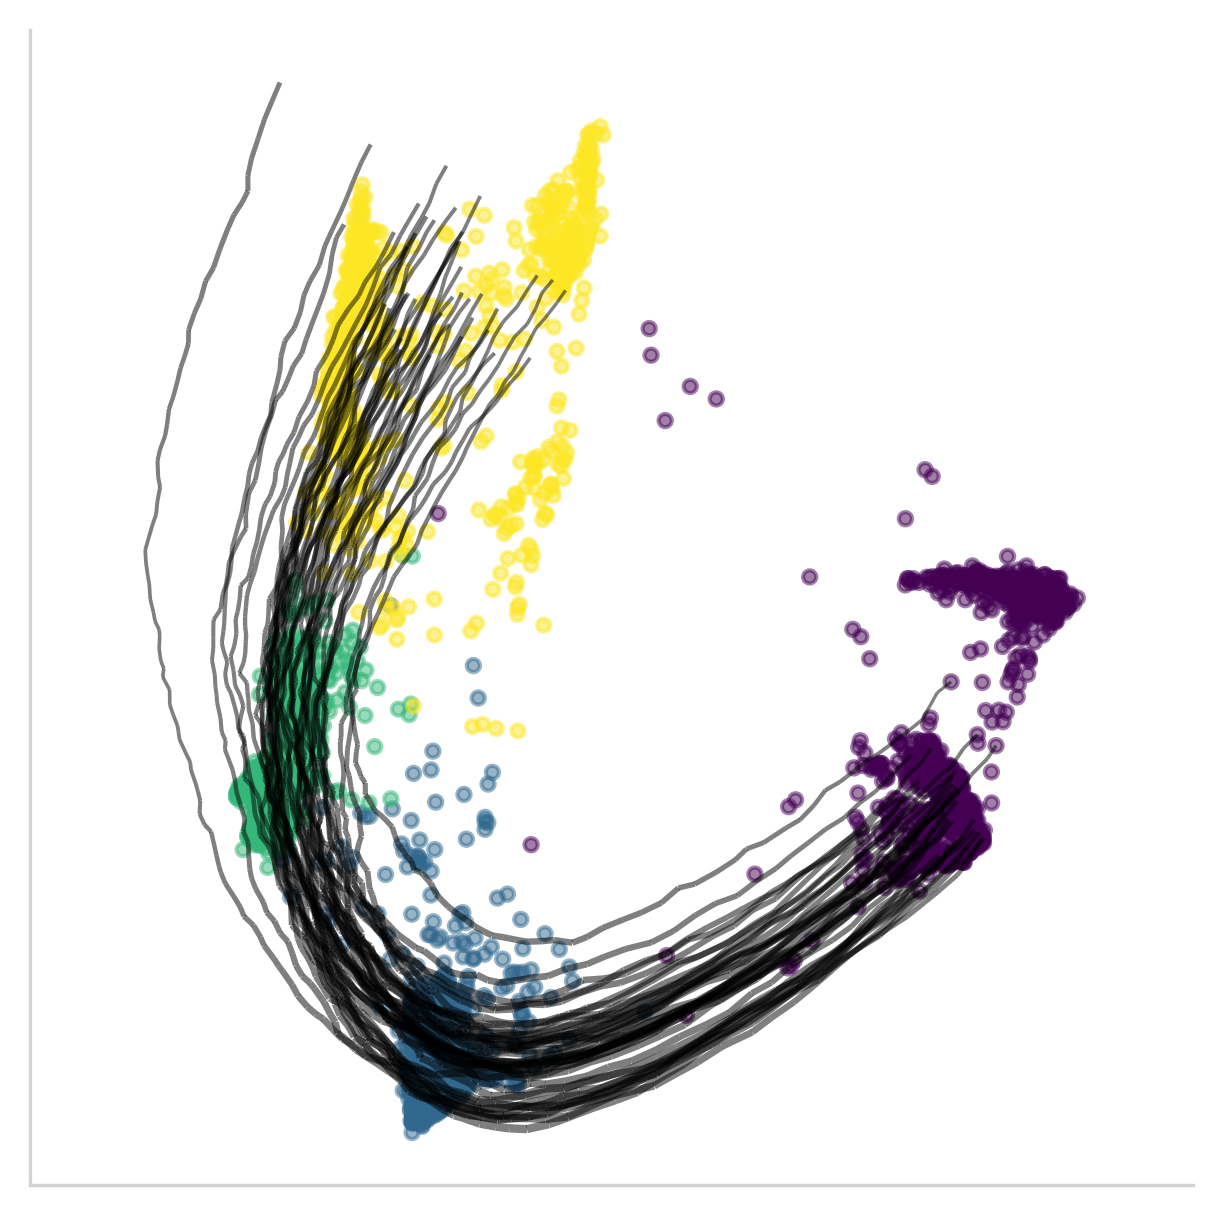

In [72]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)
    shapes = x_traj.shape
    xtflat = x_traj.flatten(0,1)
    m_traj = gmodel(xtflat).reshape(shapes[0], shapes[1], -1)
plt.figure(figsize=(5, 5))
scatter = plt.scatter(df0['d1'], df0['d2'],
                c=df0['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

from matplotlib.collections import LineCollection

# m_trajt = m_traj_softmax/ m_traj_softmax.max()
m_trajt = m_traj.squeeze()
m_trajt = (m_trajt - m_trajt.min()) / (m_trajt.max() - m_trajt.min()) * 2
# when m_
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(df0['d1'], df0['d2'],
                c=df0['samples'] , cmap='viridis', s=10, alpha=.5)
subsampled_points = np.random.choice(x_traj.shape[1], 40, replace=False)
for i in subsampled_points:
    # Use the width array to determine the linewidths for this trajectory
    traj = x_traj[:,i,:]
    linewidths = m_trajt[:,i]
    
    # Create segments for the trajectory
    segments = [np.array([traj[j], traj[j+1]]) for j in range(len(traj)-1)]
    
    # Create a LineCollection with the segments and the corresponding linewidths
    lc = LineCollection(segments, linewidths=linewidths, color='black', alpha=0.5)
    plt.gca().add_collection(lc)

    # Add the arrow at the end of the trajectory
    # plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
    #              arrowprops=dict(arrowstyle="-|>", color='Black', lw=.05))
# Autoscale to adjust plot limits
plt.gca().autoscale()
plt.xticks([])  # Hides x-axis ticks
plt.yticks([])  # Hides y-axis ticks
plt.axis('equal')

plt.show()

filter_idx = x_traj[-1, :, 1] < 2
x_traj = x_traj[:, filter_idx, :]
m_traj = m_traj[:, filter_idx, :]
m_trajt = m_trajt[:, filter_idx]

In [73]:
# Load original model weights
gmodel_orig = torch.load('gmodel_full.pt')

# Compare weights between trained and original model
for (name1, param1), (name2, param2) in zip(gmodel.named_parameters(), gmodel_orig.named_parameters()):
    if not torch.allclose(param1, param2):
        print(f"Parameters differ in layer {name1}")
        print(f"Max difference: {(param1 - param2).abs().max().item()}")


Parameters differ in layer mlp.0.weight
Max difference: 0.012370407581329346
Parameters differ in layer mlp.0.bias
Max difference: 0.011228935793042183
Parameters differ in layer mlp.2.weight
Max difference: 0.01511312648653984
Parameters differ in layer mlp.2.bias
Max difference: 0.010100136511027813
Parameters differ in layer mlp.4.weight
Max difference: 0.010331925936043262
Parameters differ in layer mlp.4.bias
Max difference: 0.008680522441864014


In [74]:
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, 1., size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor([0.,1.], dtype=data_t0.dtype, device=data_t0.device)
data_tp = model(data_t0, sample_time, return_whole_sequence=False)
m_t1 = gmodel(data_t0).flatten()
loss = criterion(data_tp, data_t1, source_mass=m_t1)

# Test if loss has gradients w.r.t gmodel parameters
loss.backward()
has_gradients = any(param.grad is not None for param in gmodel.parameters())
print("Loss has gradients w.r.t gmodel parameters:", has_gradients)

# Print gradient values for debugging
for name, param in gmodel.named_parameters():
    if param.grad is not None:
        print(f"Gradient for {name}:", param.grad.norm().item())
    else:
        print(f"No gradient for {name}")

# Zero gradients after checking
gmodel.zero_grad()

Loss has gradients w.r.t gmodel parameters: True
Gradient for mlp.0.weight: 0.0163157656788826
Gradient for mlp.0.bias: 0.011645055375993252
Gradient for mlp.2.weight: 0.009200088679790497
Gradient for mlp.2.bias: 0.007527668960392475
Gradient for mlp.4.weight: 0.012194455601274967
Gradient for mlp.4.bias: 0.017193062230944633


/Users/xingzhi/micromamba/envs/nflo/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [75]:
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, 1., size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor([0.,1.], dtype=data_t0.dtype, device=data_t0.device)
data_tp = model(data_t0, sample_time, return_whole_sequence=False)
m_t1 = gmodel(data_t0).flatten()
criterion2 = OT_loss(which='sinkhorn_knopp_unbalanced', use_cuda=use_cuda, detach_mass=False)
loss = criterion2(data_tp, data_t1, source_mass=m_t1)

# Test if loss has gradients w.r.t gmodel parameters
loss.backward()
has_gradients = any(param.grad is not None for param in gmodel.parameters())
print("Loss has gradients w.r.t gmodel parameters:", has_gradients)

# Print gradient values for debugging
for name, param in gmodel.named_parameters():
    if param.grad is not None:
        print(f"Gradient for {name}:", param.grad.norm().item())
    else:
        print(f"No gradient for {name}")

# Zero gradients after checking
gmodel.zero_grad()

Loss has gradients w.r.t gmodel parameters: True
Gradient for mlp.0.weight: 0.10406120866537094
Gradient for mlp.0.bias: 0.05140925943851471
Gradient for mlp.2.weight: 0.04760753735899925
Gradient for mlp.2.bias: 0.014735524542629719
Gradient for mlp.4.weight: 0.05585365742444992
Gradient for mlp.4.bias: 0.01338876411318779


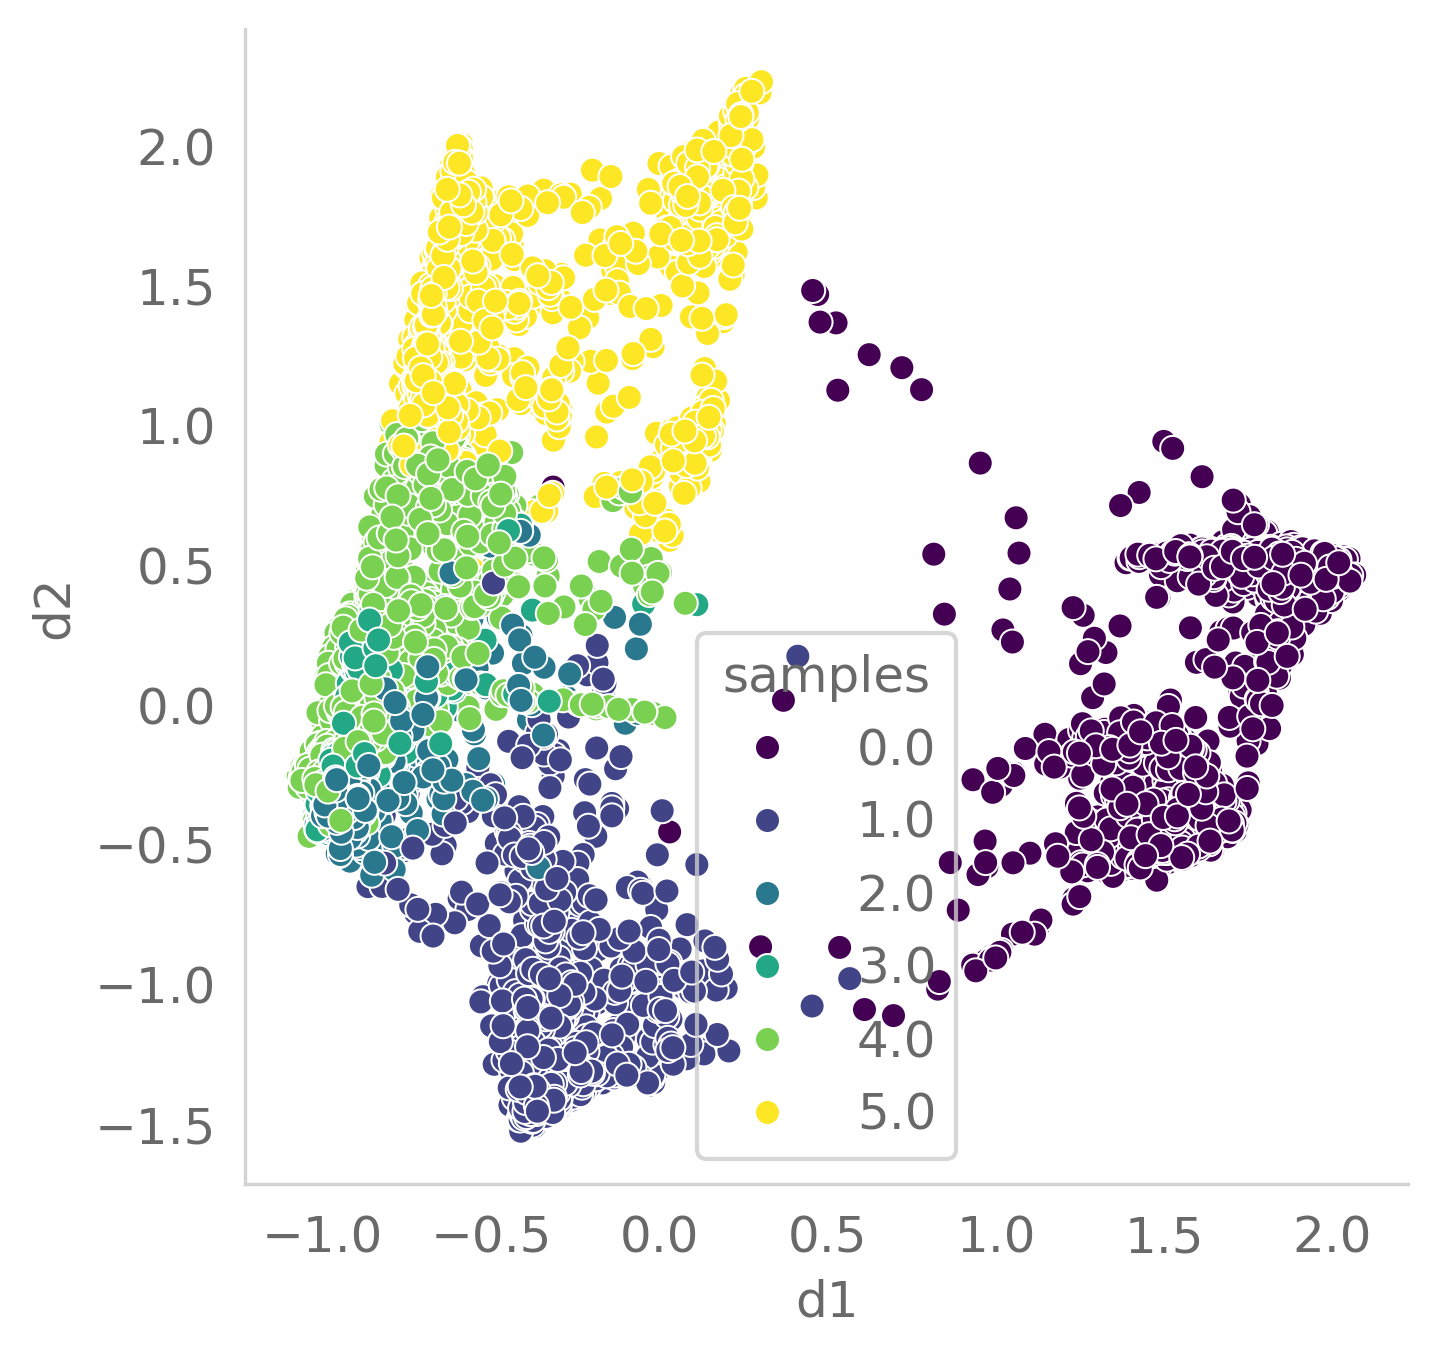

In [128]:
df2 = pd.read_csv("../data/mioflow_pseudotime.csv", index_col=0)
df2[['d1', 'd2']] = scaler.transform(df2[['d1', 'd2']])
fig = plt.figure(figsize=(5, 5), dpi=300)
sns.scatterplot(data=df2, x='d1', y='d2', hue='samples', palette='viridis');

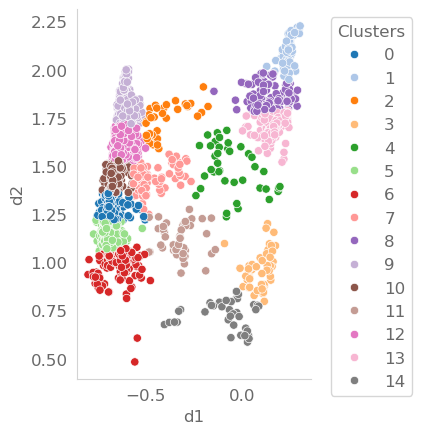

In [155]:
# cluster "starting" points and annotate trajectories
np.random.seed(32)
t0_df = df2[df2['samples'] == 5].copy()
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15)
t0_df['cluster'] = kmeans.fit_predict(t0_df[['d1', 'd2']])

# Create scatter plot using seaborn
scatter = sns.scatterplot(data=t0_df, x='d1', y='d2', hue='cluster', palette='tab20')

# Add legend
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal')

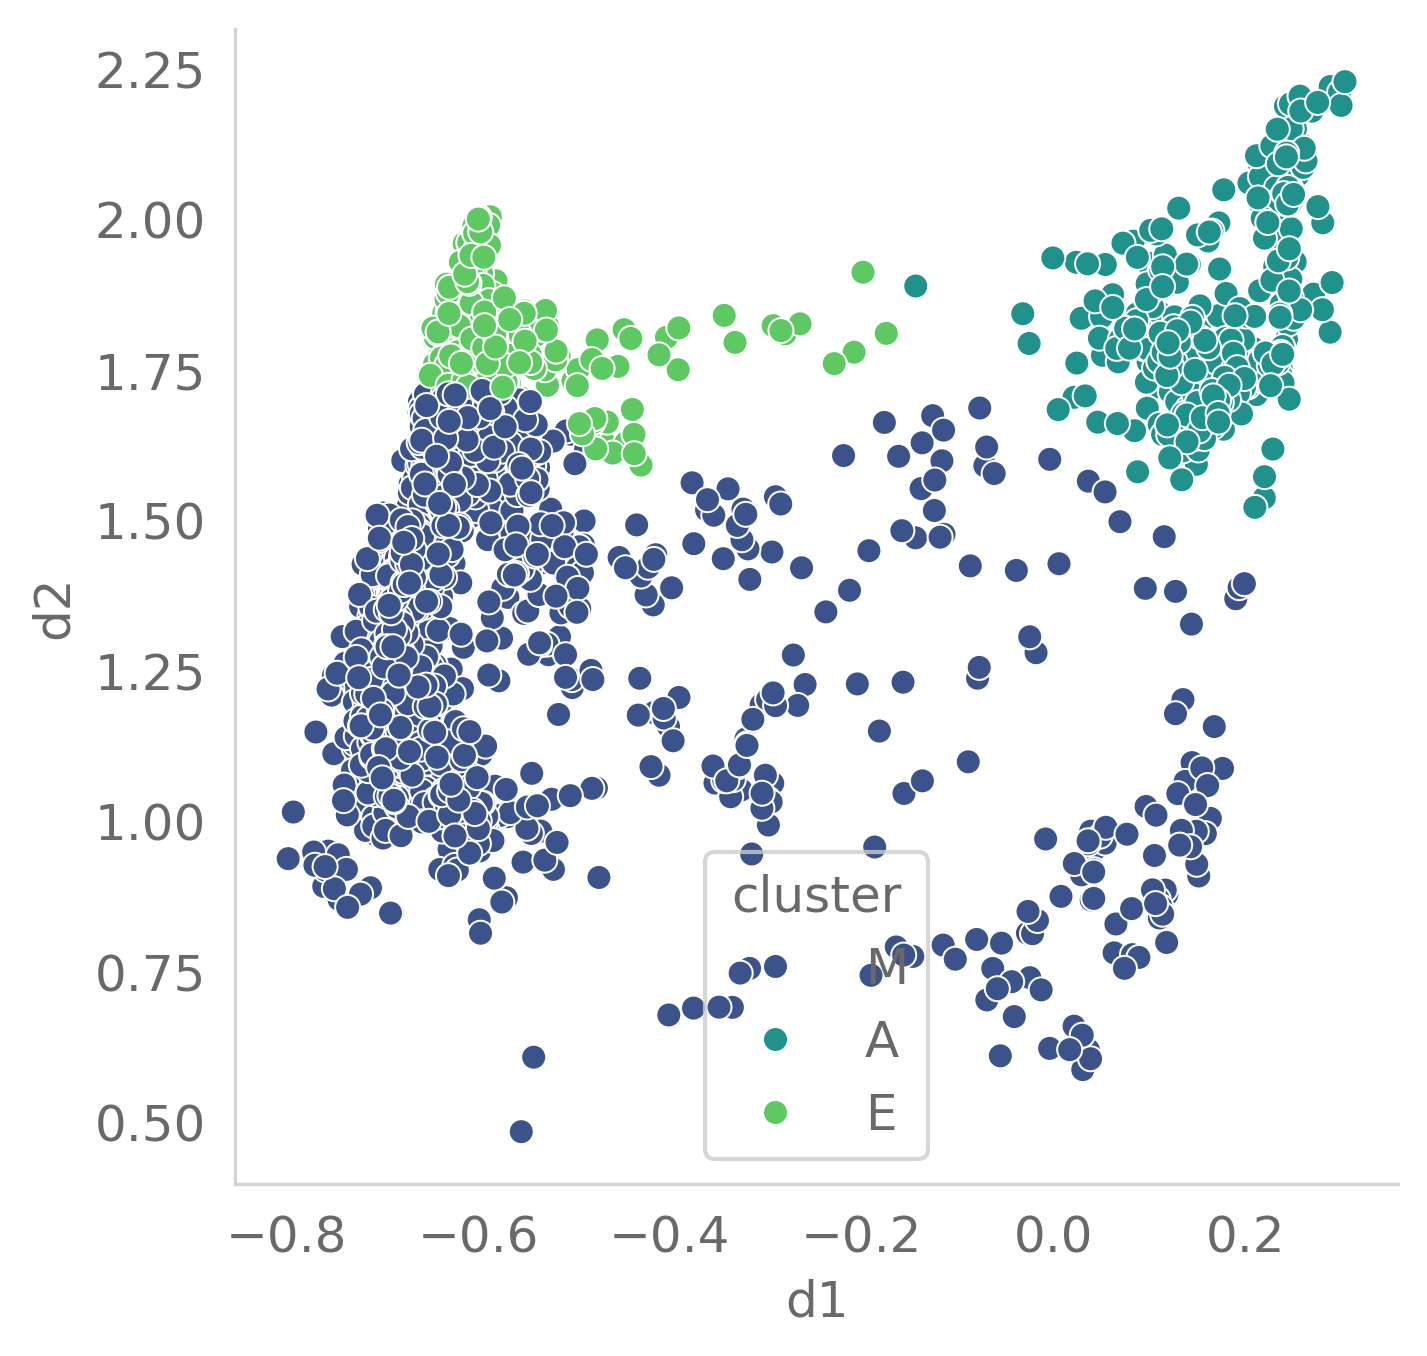

In [156]:

A_idx = [1,8,13]
E_idx = [2,9]
M_idx = [0,3,4,5,6,7,10,11,12,14]
cluster_dict = {}
for idx in A_idx:
    cluster_dict[idx] = 'A'
for idx in E_idx:
    cluster_dict[idx] = 'E'
for idx in M_idx:
    cluster_dict[idx] = 'M'
    
t0_df['cluster'] = t0_df['cluster'].map(cluster_dict)
fig = plt.figure(figsize=(5, 5), dpi=300)
sns.scatterplot(data=t0_df, x='d1', y='d2', hue='cluster', palette='viridis');

<Axes: xlabel='None', ylabel='None'>

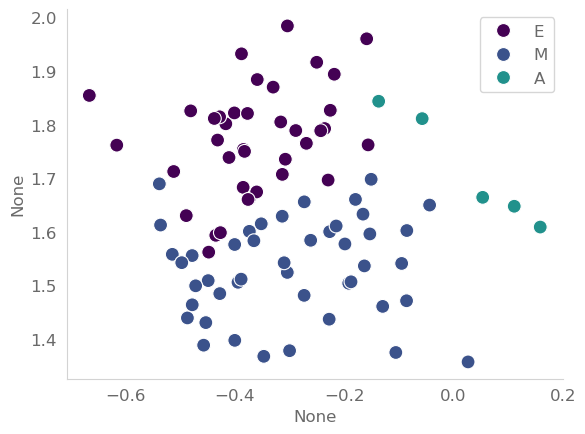

In [157]:
end_points = x_traj[-1, :, :]
# Get t0_df points as numpy array for distance calculation
t0_points = t0_df[['d1', 'd2']].values
# Calculate pairwise distances between end points and t0 points
distances = np.sqrt(((end_points[:, None, :] - t0_points[None, :, :]) ** 2).sum(axis=2))
# Find index of nearest t0 point for each end point
nearest_indices = distances.argmin(axis=1)
# Get corresponding clusters
end_point_clusters = t0_df['cluster'].values[nearest_indices]

sns.scatterplot(x=end_points[:, 0], y=end_points[:, 1], hue=end_point_clusters, s=100, alpha=1)


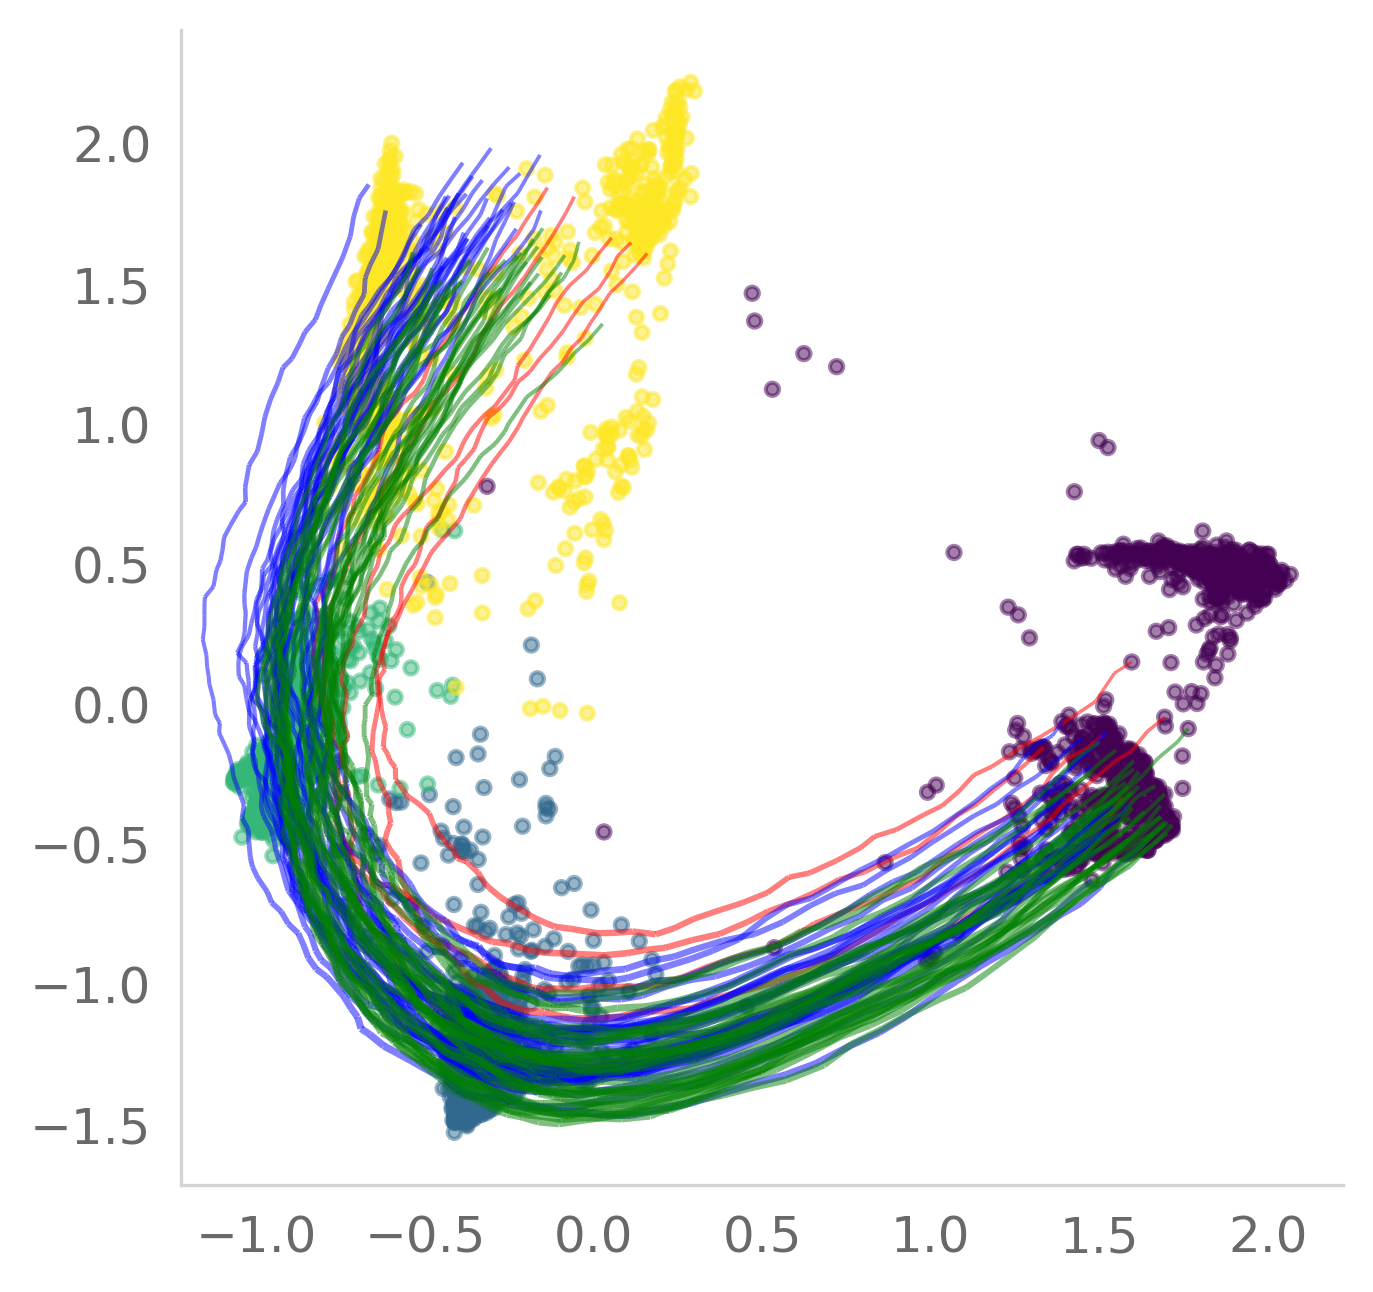

In [171]:
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(df0['d1'], df0['d2'],
                c=df0['samples'] , cmap='viridis', s=10, alpha=.5)
color_dict = {
    'A': 'red',
    'E': 'blue',
    'M': 'green',
}
np.random.seed(10)

for i, c in enumerate(np.unique(end_point_clusters)):
    trajs = x_traj[:,end_point_clusters == c,:]
    mtrajs = m_trajt[:,end_point_clusters == c]
    subsampled_points = np.random.choice(trajs.shape[1], min(trajs.shape[1],30), replace=False)
    # subsampled_points = np.arange(trajs.shape[1])
    for i in subsampled_points:
        # Use the width array to determine the linewidths for this trajectory
        traj = trajs[:,i,:]
        linewidths = mtrajs[:,i]
        
        # Create segments for the trajectory
        segments = [np.array([traj[j], traj[j+1]]) for j in range(len(traj)-1)]
        
        # Create a LineCollection with the segments and the corresponding linewidths
        lc = LineCollection(segments, linewidths=linewidths, color=color_dict[c], alpha=0.5)
        plt.gca().add_collection(lc)


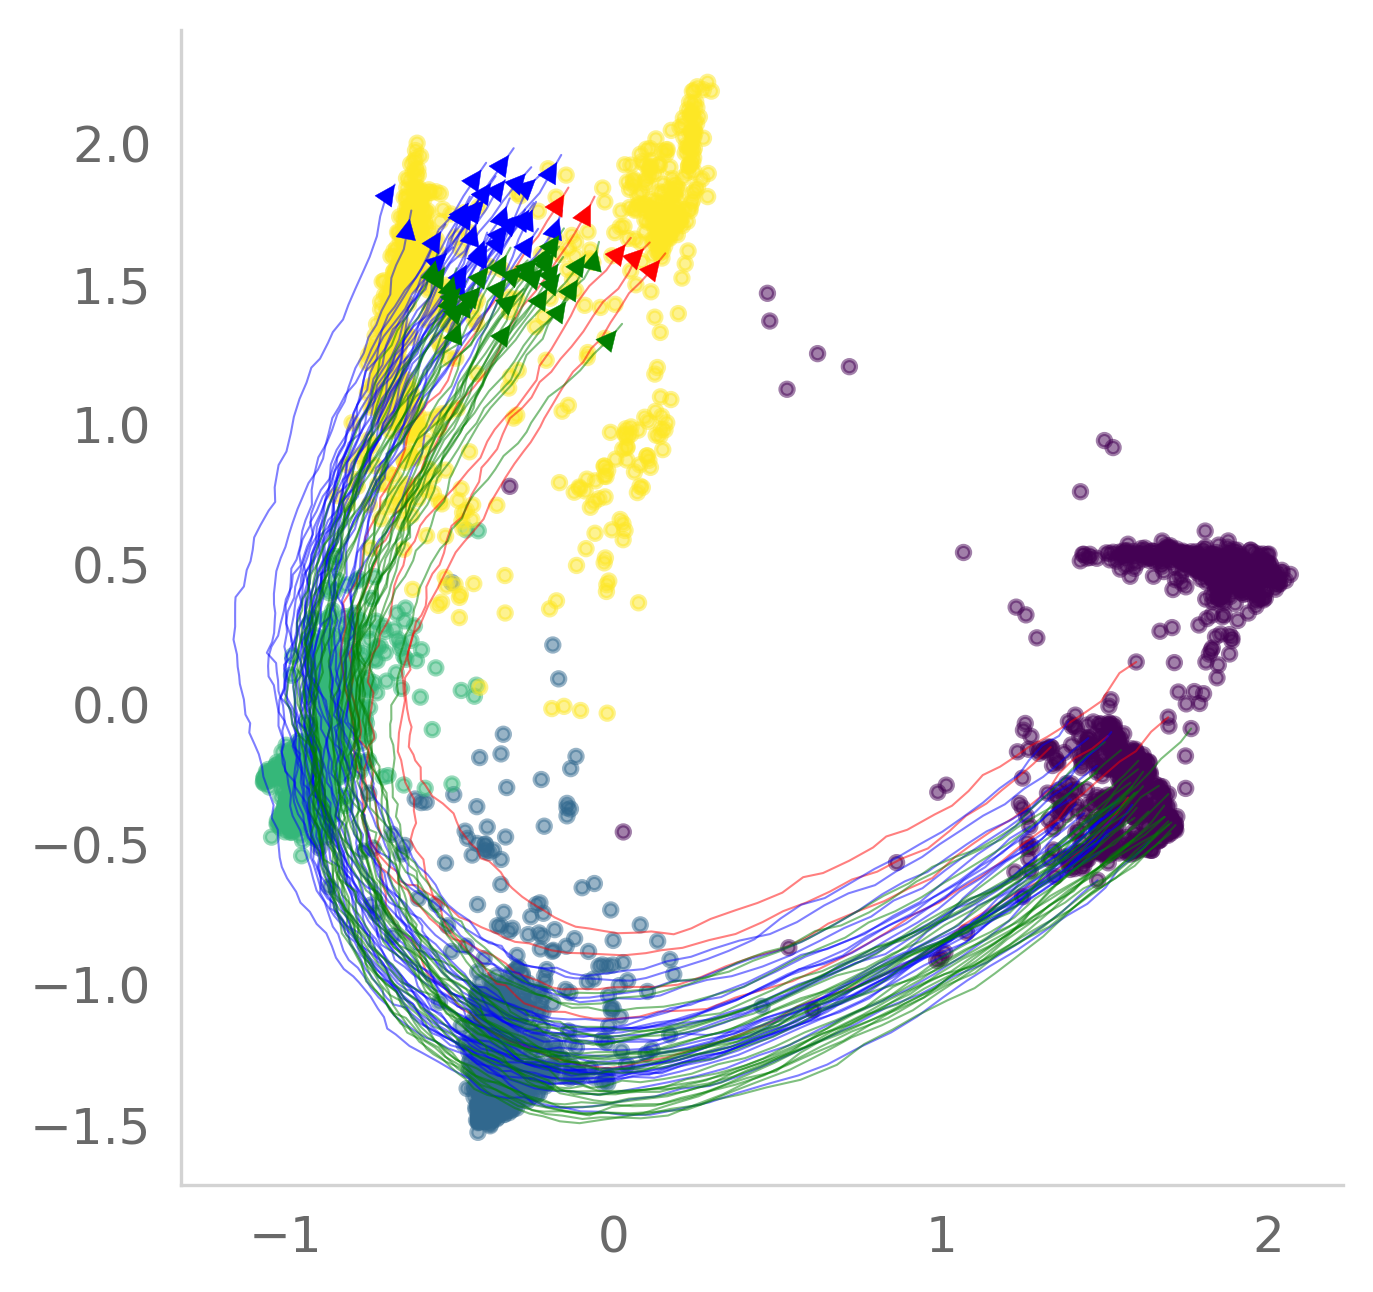

In [172]:
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(df0['d1'], df0['d2'],
                c=df0['samples'] , cmap='viridis', s=10, alpha=.5)
color_dict = {
    'A': 'red',
    'E': 'blue',
    'M': 'green',
}
np.random.seed(10)
for i, c in enumerate(np.unique(end_point_clusters)):
    trajs = x_traj[:,end_point_clusters == c,:]
    mtrajs = m_trajt[:,end_point_clusters == c]
    # subsampled_points = np.random.choice(x_traj.shape[1], 100, replace=False)
    # subsampled_points = np.arange(trajs.shape[1])
    subsampled_points = np.random.choice(trajs.shape[1], min(trajs.shape[1],30), replace=False)
    for j in subsampled_points:
        # Use the width array to determine the linewidths for this trajectory
        traj = trajs[:,j,:]
        plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color=color_dict[c]);
        plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                    arrowprops=dict(arrowstyle="-|>", color=color_dict[c], lw=.1))


In [160]:
# saving the trajectories and generated points
# np.save(os.path.join(exp_dir,'trajectories_petal.npy'),trajectories)
# np.save(os.path.join(exp_dir,'generated_petal.npy'),generated)

In [161]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [162]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [163]:
RES_DIR

'/Users/xingzhi/Research/MIOFlow_conditional/results'

In [164]:
exp_dir

'/Users/xingzhi/Research/MIOFlow_conditional/results/test'

In [165]:
# np.random.seed(32)
# groups = sorted(df['samples'].unique())
# sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
# from MIOFlow.utils import sample
# data_t0 = sample(
#     df, np.min(groups), size=(n_points, ), 
#     replace=False, to_torch=True, use_cuda=use_cuda
# )
# sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

# with torch.no_grad():
#     x_traj = model(data_t0, sample_time, return_whole_sequence=True)

# savepath = './'
# np.save(os.path.join(savepath, 'trajectories.npy'), x_traj)

In [166]:
trajectories.shape

(100, 100, 2)